# Timeseries forecasting using Sktime

*Dies ist eine einfache Prognose mit Sktime für das Thema Zeitreihenanalysen, da ich dieses Semester mit der Aufgabe Zeitreihenanalysen startete. Allerdings habe ich aufgrund von wiederkehrenden Problemen den Datensatz zu den "Used Car Auction Prices"-Daten gewechselt. Aufgrund des Wechsels ist das "Timeseries forecasting using Sktime"-Notebook das einzige Notebook, welches ansatzweise fertiggestellt werden konnte.* 

Innerhalb dieses Notebooks wird mithilfe der Python Bibliothek Sktime eine Prognose für die zukünftigen Verkäufe von (einem) Produkt(en) durchgeführt. Dabei werden die Daten der m5-competition von Walmart herangezogen.

# Import Data and Packages

Für die Durchführung der Zeitreihenanalyse wird die Python-Bibliothek Sktime verwendet. Zusätzlich werden Visualisierungen mit der Bibliothek Matplotlib durchgeführt.

In [305]:
from warnings import simplefilter

import numpy as np
import pandas as pd

from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    TransformedTargetForecaster,
    make_reduction,
)
from sktime.forecasting.model_selection import (
    temporal_train_test_split,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import (
    MeanAbsolutePercentageError,
    mean_absolute_percentage_error,
)
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series

simplefilter("ignore", FutureWarning)
%matplotlib inline

import matplotlib.pyplot as plt

Für die Anwendung der Zeitreihenanalyse verwenden wir die Datensätze **Sales_train_evaluation.csv** und **Calender.csv**. Diese werden mithilfe von Pandas eingelesen.

In [306]:
df_stv = pd.read_csv("/Users/lukas/Documents/MLOPS/PL/sales_train_evaluation.csv")
df_cal = pd.read_csv("/Users/lukas/Documents/MLOPS/PL/calendar.csv")

# Overview

Zuerst betrachten wir die relevanten Dataframes df_stv und df_cal.

In [307]:
df_stv.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [308]:
df_cal.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


# Data format

Für die Anwendung der Bibliothek Sktime müssen die Daten angepasst und formatiert werden. Hierfür wird zuerst ein Dataframe so angepasst, dass er zwei Spalten aufweist das Datum und die Verkaufszahlen pro Datum (Tag) eines Produktes. <br><br>
*Anzumerken ist dabei, dass die Zeitreihenprognose in diesem Beispiel vereinfacht umgesetzt wird*

Zuerst fügen wir die Dataframes "df_stv" und "df_cal" basierend auf der Tagesnummerierung zusammen.

In [309]:
#Erstellung einer Liste mit den nummerierten Tagen "d"
list_d_ = [i for i in df_stv.columns if 'd_' in i] 
list_d_
list_none = []
for i in range(6):
    list_none.append("None")
list_d_ = list_none + list_d_

In [310]:
# Zusammenführung von date und Tagesnummerierung
date_d = dict(zip(df_cal.date, df_cal.d))

In [311]:
# Transpose df_stv
df_stv = df_stv.T

In [312]:
# Erstellung der Spalte "d" mit Daten aus der Liste "list_d_"
df_stv["d"] = list_d_

In [313]:
# Zusammenführung der Dataframes basierend auf der Spalte "d"
df_stv = pd.merge(df_stv, df_cal, on="d")

In [314]:
df_stv.head(10)

,0,1,2,3,4,5,6,7,8,9,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,0,0,0,0,0,0,0,12,2,0,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,0,0,0,0,0,0,0,15,0,0,...,2,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,0,0,0,0,0,0,0,0,7,1,...,3,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,0,0,0,0,0,0,0,0,3,0,...,4,2,2011,NaN,NaN,NaN,NaN,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,5,2,2011,NaN,NaN,NaN,NaN,1,0,1
5,0,0,0,0,0,0,0,4,2,0,...,6,2,2011,NaN,NaN,NaN,NaN,1,1,1
6,0,0,0,0,0,0,0,6,3,0,...,7,2,2011,NaN,NaN,NaN,NaN,1,0,0
7,0,0,0,0,0,0,0,5,9,0,...,1,2,2011,NaN,NaN,NaN,NaN,1,1,1
8,0,0,0,0,0,0,0,7,0,0,...,2,2,2011,SuperBowl,Sporting,NaN,NaN,1,1,1
9,0,0,0,0,0,0,0,0,0,0,...,3,2,2011,NaN,NaN,NaN,NaN,1,1,0


Nun reduzieren wir den Dataframe auf die nötigsten Spalten.

In [315]:
df_example = df_stv[["date",0]]

In [316]:
df_example.head()

,date,0
0,2011-01-29,0
1,2011-01-30,0
2,2011-01-31,0
3,2011-02-01,0
4,2011-02-02,0


In [317]:
df_example.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1941 entries, 0 to 1940
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    1941 non-null   object
 1   0       1941 non-null   object
dtypes: object(2)
memory usage: 45.5+ KB


Anschließend passen wir den Datentyp des Produkts an.

In [318]:
df_example[0] = df_example[0].astype(float)

/var/folders/df/nc1vtthj247d1h5l5689kdxh0000gn/T/ipykernel_33344/4201989889.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_example[0] = df_example[0].astype(float)


Um besser mit der Bibliothek Matplotlib arbeiten zu können wandeln wir den Dataframe in eine Pandasseries um. Zuvor setzen wir jedoch die Spalte "date" als Index.

In [319]:
df_series = df_example.set_index('date') # Index "date" wird gesetzt

In [320]:
df_series.index = pd.to_datetime(df_series.index, errors='coerce') # Index zu Datetime konvertieren
df_series.asfreq('D') # Hinzufügen der Frequenz

,0
date,
2011-01-29,0.0
2011-01-30,0.0
2011-01-31,0.0
2011-02-01,0.0
2011-02-02,0.0
...,...
2016-05-18,0.0
2016-05-19,3.0
2016-05-20,3.0


In [321]:
df_series.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1941 entries, 2011-01-29 to 2016-05-22
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1941 non-null   float64
dtypes: float64(1)
memory usage: 30.3 KB


In [322]:
m5_series = df_series.squeeze() # Umwandlung mittels Squeeze

In [323]:
type(m5_series)

pandas.core.series.Series

In [324]:
m5_series

date
2011-01-29    0.0
2011-01-30    0.0
2011-01-31    0.0
2011-02-01    0.0
2011-02-02    0.0
             ... 
2016-05-18    0.0
2016-05-19    3.0
2016-05-20    3.0
2016-05-21    0.0
2016-05-22    1.0
Name: 0, Length: 1941, dtype: float64

Nun wurden die Daten soweit vorbereitet, dass die Prognose und benötigte Plots zur Visualisierung effektiv dargestellt werden können.

## Sales Overview

Mithilfe von Matplotlib visualisieren wir die Produktverkäufe.

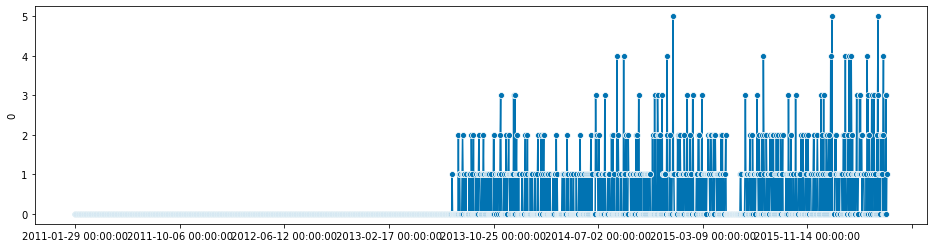

In [325]:
plot_series(m5_series);

index represents the timepoints

In [326]:
m5_series.index

DatetimeIndex(['2011-01-29', '2011-01-30', '2011-01-31', '2011-02-01',
               '2011-02-02', '2011-02-03', '2011-02-04', '2011-02-05',
               '2011-02-06', '2011-02-07',
               ...
               '2016-05-13', '2016-05-14', '2016-05-15', '2016-05-16',
               '2016-05-17', '2016-05-18', '2016-05-19', '2016-05-20',
               '2016-05-21', '2016-05-22'],
              dtype='datetime64[ns]', length=1941, freq=None)

In [327]:
m5_series = m5_series.asfreq("D")

# Data Split

Nun führen wir einen einfachen Datensplit durch.

1905 36


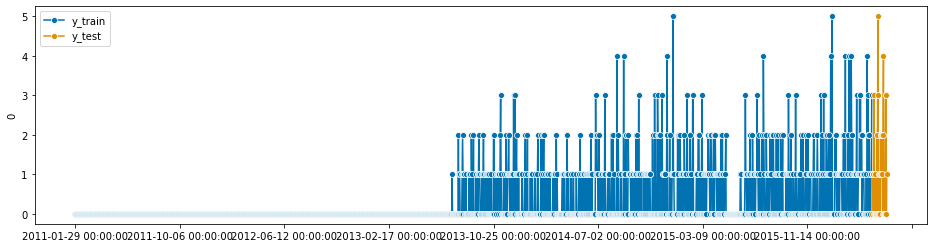

In [328]:
y_train, y_test = temporal_train_test_split(m5_series, test_size=36)
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

# Forecasting horizon

Nun definieren wir den Vorraussagezeitraum (fh).

In [329]:
fh = np.arange(len(y_test)) + 1
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36])

In [330]:
fh = np.array([2, 5])  # 2nd and 5th step ahead

In [331]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

ForecastingHorizon(['2016-04-17', '2016-04-18', '2016-04-19', '2016-04-20',
               '2016-04-21', '2016-04-22', '2016-04-23', '2016-04-24',
               '2016-04-25', '2016-04-26', '2016-04-27', '2016-04-28',
               '2016-04-29', '2016-04-30', '2016-05-01', '2016-05-02',
               '2016-05-03', '2016-05-04', '2016-05-05', '2016-05-06',
               '2016-05-07', '2016-05-08', '2016-05-09', '2016-05-10',
               '2016-05-11', '2016-05-12', '2016-05-13', '2016-05-14',
               '2016-05-15', '2016-05-16', '2016-05-17', '2016-05-18',
               '2016-05-19', '2016-05-20', '2016-05-21', '2016-05-22'],
              dtype='datetime64[ns]', freq='D', is_relative=False)

# Model - Timeseries forecasts

0.6759259259259259

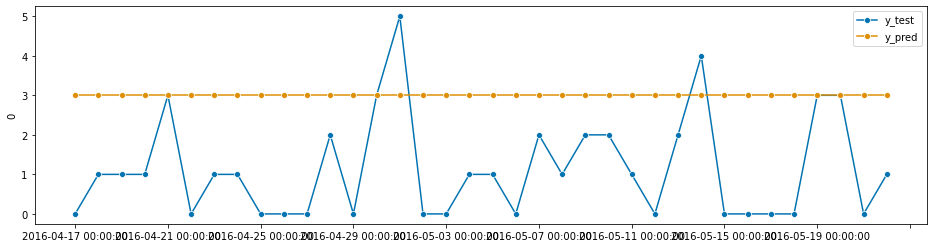

In [332]:
#Forecast basierend auf dem letzten Wert
forecaster = NaiveForecaster(strategy="last")

#Model fit
forecaster.fit(y_train)

#predict values
y_pred = forecaster.predict(fh)

plot_series(y_test, y_pred, labels=["y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

1125899906842624.2

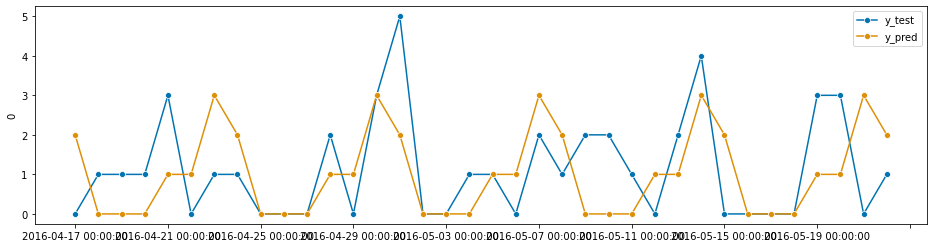

In [333]:
#Forecast basierend auf den Werten der Vorwoche (letzten Woche der Trainingsdaten)
forecaster = NaiveForecaster(strategy="last", sp=7)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

plot_series(y_test, y_pred, labels=["y_test", "y_pred"])

mean_absolute_percentage_error(y_pred, y_test)

# Sales in California
## Data Format

Nun sollen nicht nur die Verkäufe eines Produkts sondern die Verkäufe von allen Stores in Kalifornien vorhergesagt werden. Hierfür werden die Zeilen der Produkte zusammenaddiert und wie in den oberen Schritten angepasst.

In [334]:
# Import data
df_stv_ca = pd.read_csv("/Users/lukas/Documents/MLOPS/PL/sales_train_evaluation.csv")
df_cal_ca = pd.read_csv("/Users/lukas/Documents/MLOPS/PL/calendar.csv")
# Hinzufügen von Zeile, welche Verkäufe von Kalifornien zusammenfasst
df_stv_ca = df_stv_ca[df_stv_ca["state_id"] == "CA"]
total = df_stv_ca.sum()
df_stv_ca = df_stv_ca.append(total,ignore_index=True)
# Zusammenführen der Dataframes
list_d_ = [i for i in df_stv_ca.columns if 'd_' in i] 
list_d_
list_none = []
for i in range(6):
    list_none.append("None")
list_d_ = list_none + list_d_
date_d = dict(zip(df_cal_ca.date, df_cal_ca.d))
df_stv_ca = df_stv_ca.T
df_stv_ca["d"] = list_d_
df_stv_ca = pd.merge(df_stv_ca, df_cal_ca, on="d")
# Selektion der relevanten Spalten
df_ca = df_stv_ca[["date",12196]]
df_ca[12196] = df_ca[12196].astype(float)
df_ca = df_ca.set_index('date')
df_ca.index = pd.to_datetime(df_ca.index, errors='coerce')
df_ca.asfreq('D')
m5_series_total_ca = df_ca.squeeze()

/var/folders/df/nc1vtthj247d1h5l5689kdxh0000gn/T/ipykernel_33344/4139357108.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ca[12196] = df_ca[12196].astype(float)


In [335]:
m5_series_total_ca = m5_series_total_ca.asfreq("D") # Frequenz setzen

In [336]:
m5_series_total_ca

date
2011-01-29    14195.0
2011-01-30    13805.0
2011-01-31    10108.0
2011-02-01    11047.0
2011-02-02     9925.0
               ...   
2016-05-18    15678.0
2016-05-19    16297.0
2016-05-20    17430.0
2016-05-21    23103.0
2016-05-22    24644.0
Freq: D, Name: 12196, Length: 1941, dtype: float64

Nun erstellen wir ein einfaches Plot, um einen Überblick über die Verkäufe in Kalifornien zu erhalten.

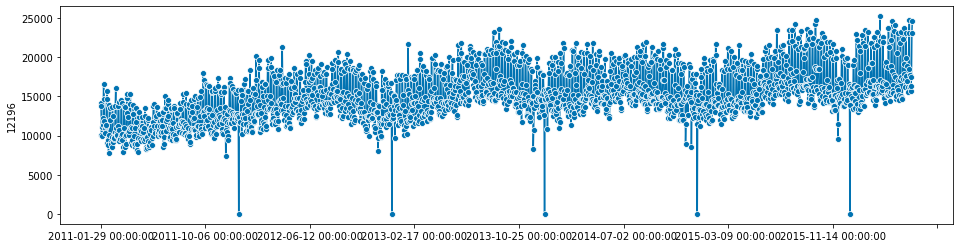

In [337]:
plot_series(m5_series_total_ca);

## Data Split

Anschließend folgt der Datensplit in Trainings- und Testdaten.

1905 36


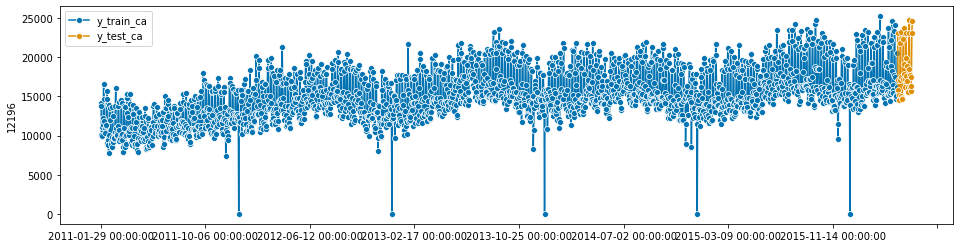

In [338]:
y_train_ca, y_test_ca = temporal_train_test_split(m5_series_total_ca, test_size=36)
plot_series(y_train_ca, y_test_ca, labels=["y_train_ca", "y_test_ca"])
print(y_train_ca.shape[0], y_test_ca.shape[0])

## Model

Nun definieren wir den Vorraussagehorizont (fh_ca).

In [339]:
fh_ca = ForecastingHorizon(y_test_ca.index, is_relative=False)
fh_ca

ForecastingHorizon(['2016-04-17', '2016-04-18', '2016-04-19', '2016-04-20',
               '2016-04-21', '2016-04-22', '2016-04-23', '2016-04-24',
               '2016-04-25', '2016-04-26', '2016-04-27', '2016-04-28',
               '2016-04-29', '2016-04-30', '2016-05-01', '2016-05-02',
               '2016-05-03', '2016-05-04', '2016-05-05', '2016-05-06',
               '2016-05-07', '2016-05-08', '2016-05-09', '2016-05-10',
               '2016-05-11', '2016-05-12', '2016-05-13', '2016-05-14',
               '2016-05-15', '2016-05-16', '2016-05-17', '2016-05-18',
               '2016-05-19', '2016-05-20', '2016-05-21', '2016-05-22'],
              dtype='datetime64[ns]', freq='D', is_relative=False)

Im nächsten Schritt wird ein einfaches Modell erstellt, um basierend auf der Vorwoche die Anzahl der Verkäufe vorherzusagen. <br> Das Modell dient dabei primär als Vergleichswert.

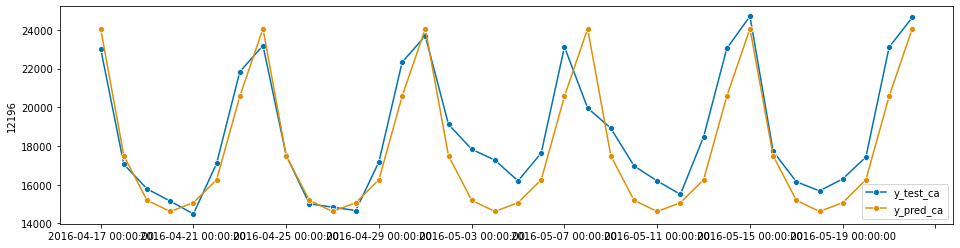

In [340]:
#Forecast basierend auf den Werten der Vorwoche (letzten Woche der Trainingsdaten)
forecaster = NaiveForecaster(strategy="last", sp=7)

forecaster.fit(y_train_ca)
y_pred_ca = forecaster.predict(fh_ca)

plot_series(y_test_ca, y_pred_ca, labels=["y_test_ca", "y_pred_ca"])

mape_baseline = mean_absolute_percentage_error(y_pred_ca, y_test_ca)

Nun wird ein Modell mit k-nearest neighbors zur Prognose der Verkaufszahlen erstellt.

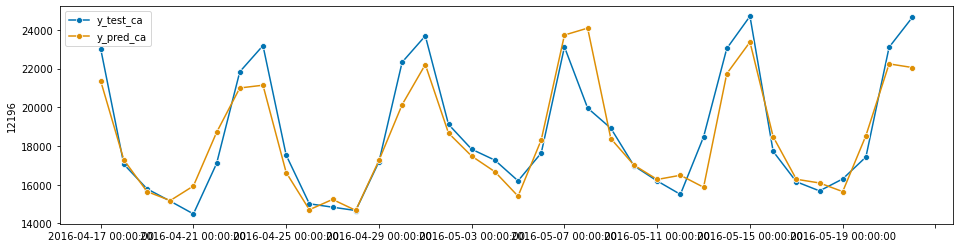

In [341]:
regressor = KNeighborsRegressor(n_neighbors=2)

forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=7)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=4))),
        (
            "forecast",
            make_reduction(
                regressor,
                scitype="tabular-regressor",
                window_length=15,
                strategy="recursive",
            ),
        ),
    ]
)
forecaster.fit(y_train_ca) # Modell fit
y_pred_ca = forecaster.predict(fh_ca)
plot_series(y_test_ca, y_pred_ca, labels=["y_test_ca", "y_pred_ca"])
mape_kn = mean_absolute_percentage_error(y_pred_ca, y_test_ca)

Nun vergleichen wir die Modelle basierend auf dem Mean absolute percentage error.

In [342]:
print("Mean absolute percentage error:",mape_baseline,"Baseline")
print("Mean absolute percentage error:",mape_kn,"KNeighborsRegressor")

Mean absolute percentage error: 0.06992683983731404 Baseline
Mean absolute percentage error: 0.04921355588926372 KNeighborsRegressor
